In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [2]:
# Load the dataset
df = pd.read_csv("NLP_Dataset1.csv")

In [3]:
df.head()

,AssetId,organizationid,organizationcountrycode,locationid,AssetType,AlarmLabel,AlarmMessage,Severity,ActivatedTimestamp,ClearedTimestamp,month,week,ResolutionTimeMinutes,Lemmas_No_Stop_Words,Tokens
0,001e6d91-324b-4b99-84f8-9435148de9ce,5effecae-fdee-494a-bf38-d4cb5d7cc405,US,Default Location,UPS,Battery Near End Of Life Cleared,The battery is no longer near the end of life.,WARNING,2021-01-17T23:32:55Z,2021-03-16T14:37:52Z,1.0,3,82984.950000,"['battery', 'near', 'end', 'life', 'clear']","['battery', 'near', 'end', 'of', 'life', 'clea..."
1,001e6d91-324b-4b99-84f8-9435148de9ce,5effecae-fdee-494a-bf38-d4cb5d7cc405,US,Default Location,UPS,Power Failure Cleared,No longer on battery power.,WARNING,2021-01-08T20:55:56Z,2021-01-08T20:56:19Z,1.0,2,0.383333,"['power', 'failure', 'clear']","['power', 'failure', 'cleared']"
2,004209ba-f692-41b8-af30-5b51996f1abb,a3768a07-4e2d-4075-ab6b-66e3541fc6c4,US,275102b5-af38-456c-982b-7a6d33850e13,UPS,Device Communication Alert,"Communication with the UPS \""redact\"" has been...",CRITICAL,2021-01-08T20:28:05Z,2021-01-08T20:36:14Z,1.0,2,8.150000,"['device', 'communication', 'alert']","['device', 'communication', 'alert']"
3,004209ba-f692-41b8-af30-5b51996f1abb,a3768a07-4e2d-4075-ab6b-66e3541fc6c4,US,275102b5-af38-456c-982b-7a6d33850e13,UPS,Device Communication Alert,"Communication with the UPS \""redact\"" has been...",CRITICAL,2021-01-29T11:51:23Z,2021-01-29T11:56:16Z,1.0,5,4.883333,"['device', 'communication', 'alert']","['device', 'communication', 'alert']"
4,004209ba-f692-41b8-af30-5b51996f1abb,a3768a07-4e2d-4075-ab6b-66e3541fc6c4,US,275102b5-af38-456c-982b-7a6d33850e13,UPS,Device Communication Alert,"Communication with the UPS \""redact\"" has been...",CRITICAL,2021-01-29T09:41:23Z,2021-01-29T09:46:22Z,1.0,5,4.983333,"['device', 'communication', 'alert']","['device', 'communication', 'alert']"


In [4]:
# Display data information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34813823 entries, 0 to 34813822
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   AssetId                  object 
 1   organizationid           object 
 2   organizationcountrycode  object 
 3   locationid               object 
 4   AssetType                object 
 5   AlarmLabel               object 
 6   AlarmMessage             object 
 7   Severity                 object 
 8   ActivatedTimestamp       object 
 9   ClearedTimestamp         object 
 10  month                    float64
 11  week                     int64  
 12  ResolutionTimeMinutes    float64
 13  Lemmas_No_Stop_Words     object 
 14  Tokens                   object 
dtypes: float64(2), int64(1), object(12)
memory usage: 3.9+ GB
None


In [5]:
# Display the processed data
print(df.head())

                                AssetId                        organizationid  \
0  001e6d91-324b-4b99-84f8-9435148de9ce  5effecae-fdee-494a-bf38-d4cb5d7cc405   
1  001e6d91-324b-4b99-84f8-9435148de9ce  5effecae-fdee-494a-bf38-d4cb5d7cc405   
2  004209ba-f692-41b8-af30-5b51996f1abb  a3768a07-4e2d-4075-ab6b-66e3541fc6c4   
3  004209ba-f692-41b8-af30-5b51996f1abb  a3768a07-4e2d-4075-ab6b-66e3541fc6c4   
4  004209ba-f692-41b8-af30-5b51996f1abb  a3768a07-4e2d-4075-ab6b-66e3541fc6c4   

  organizationcountrycode                            locationid AssetType  \
0                      US                      Default Location       UPS   
1                      US                      Default Location       UPS   
2                      US  275102b5-af38-456c-982b-7a6d33850e13       UPS   
3                      US  275102b5-af38-456c-982b-7a6d33850e13       UPS   
4                      US  275102b5-af38-456c-982b-7a6d33850e13       UPS   

                         AlarmLabel  \
0  Battery 

In [6]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [7]:
# Preprocessing
X = df[['AssetType', 'AlarmLabel']].copy()  # Create a copy to avoid warnings
y = df['Severity']  # Target variable

In [8]:
# Convert target variable to numeric
severity_mapping = {'INFO': 0, 'WARNING': 1, 'ERROR': 2, 'FAIL': 3, 'CRITICAL': 4}
y = y.map(severity_mapping)

In [9]:
# Target encoding for categorical variables
def target_encode(df, feature, target):
    mean_encoded = df.groupby(feature)[target].mean()
    return df[feature].map(mean_encoded)

X['AssetType_encoded'] = target_encode(pd.concat([X, y], axis=1), 'AssetType', y.name)
X['AlarmLabel_encoded'] = target_encode(pd.concat([X, y], axis=1), 'AlarmLabel', y.name)
X.drop(['AssetType', 'AlarmLabel'], axis=1, inplace=True)

In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Train the model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [12]:
# Predict on the test data
y_pred = model.predict(X_test)

In [13]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.881792219039419
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.84      0.77    676070
           1       0.99      0.87      0.93   2228326
           2       0.62      0.86      0.72    689446
           3       0.75      0.84      0.79    362795
           4       0.96      0.91      0.94   3006128

    accuracy                           0.88   6962765
   macro avg       0.81      0.86      0.83   6962765
weighted avg       0.90      0.88      0.89   6962765



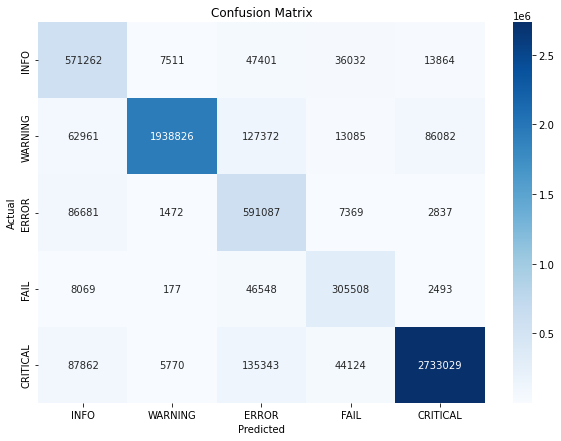

In [14]:
# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=severity_mapping.keys(), yticklabels=severity_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

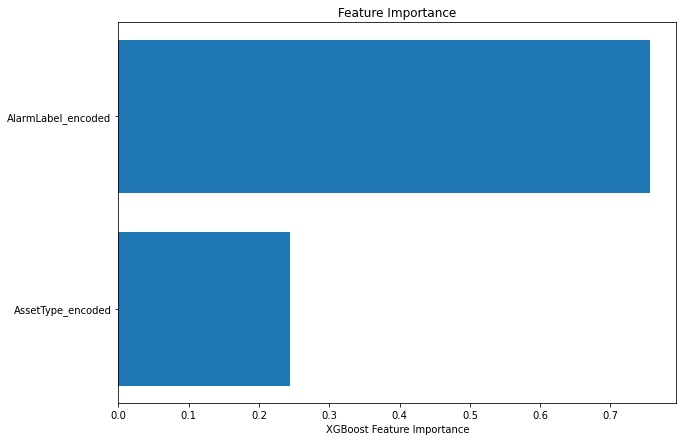

In [15]:
# Plot feature importance
plt.figure(figsize=(10,7))
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("XGBoost Feature Importance")
plt.title("Feature Importance")
plt.show()